## MEAM5460 Project 2: Trim Analysis
### Nathaniel Ruhl
### Spring 2023
### Code: https://github.com/nruhl25/HoveringVehicleDesign/tree/main/proj2

### Methodology

The goal of our "trim" is to determine the control inputs required to achieve a desired opertational state. Our desired operational state consists of 

1. Zeroing out longitudianal and lateral flapping, eg. $\beta_{1c}=\beta_{1s}=0$
2. Acheiving a specified rotor thrust ($0.005 < C_T/\sigma < 0.01$)
2. Achieving a specified forward thrust ($0.05 < C_X < 0.1$, force along wind tunnel axis)

In order to acheive these outcomes, we can make use of the following controls. While the trim is highly couples, the numbers indicate which controls are mostly closely related to which outcomes:

1. Longitudinal and lateral cyclic pitch inputs, $\theta_{1c}$ and $\theta_{1s}$
2. Input collective, $\theta_0$
3. Rotor shaft incidence angle, $\alpha$ (I sometimes call this the "rotor-disc plane tilt angle")

The total power required to maintain the operating condition is derived from the coefficient of torque $C_Q$, for which the equation is given in the problem assignment. For this formula, we assume linear airfoils with a section coefficient of drag of $c_{d_0}=0.01$ and a lift-curve slope of $c_{l_\alpha}=2\pi$. Since $P=\Omega Q$, it can be shown that $C_P=C_Q$, and the total power is thus defined as

$$Total Power = C_P \rho A v_{tip}^3$$

where the values of $\rho$, $A$, and $v_{tip}$ are given in the problem assignment. The analysis below shows the required inputs and operating state of the rotor required zero out longitudinal and lateral flapping and to achieve a specificrange of values of $C_T$ and $C_X$.

The system of equations in the problem assignment attached above are highly coupled, yet well-behaved non-linear equations that can be solved numerically. For the desired operational state, in which $\beta_{1c}=\beta_{1s}=0$ and $C_X$ and $C_T$ are specified, we can defined a set of 5 equations and 5 uknowns. The uknown variables (which I refer to as "state variables" in my code) are

$$\mathbf{x} = 
\begin{pmatrix} \beta_0 \\ \theta_0 \\ \theta_{1c} \\ \theta_{1s} \\ \lambda \end{pmatrix}.$$

The non-linear system of equations can be written as $f(\mathbf{x})=0$, where

$$ f(\mathbf{x}) = 
\begin{pmatrix}
A_{11} \beta_0 - c_1 \\
A_{21} \beta_0 - c_2 \\
A_{31} \beta_0 - c_3 \\
\lambda - \lambda_{RHS} \\
C_T - C_{T,RHS}
\end{pmatrix}
$$

The entries of the 3x3 matrix $\mathbf{A}$ and the 3x1 column vector $\mathbf{c}$ are given in the project assignment (I defined the matrix equation as $\mathbf{A \beta} = \mathbf{c}$). The root $\mathbf{x}^*$ can be solved by Newton's method, for which I have used ``scipy.optimize.fsolve``. The algorithm is not very sensitive to initial guesses, and even $\mathbf{x_0}=[0;0;0;0;0]$ suffices.

The specifications of our articulated rotor are defined in the project assignment, and defined as global variables in ``proj2.py``. Furthermore, in this analysis, I have used a typical Locke numer of $\gamma=7$ since we do not know the moment of inertia of the aircraft.

I will discuss the results below and show snippets of my code, which can be adapted to perform further analysis.

In [1]:
import numpy as np
import importlib
import matplotlib.pyplot as plt

# local modules
import proj2
import plotter

importlib.reload(proj2)
importlib.reload(plotter)
from proj2 import calc_trims_array, plot_rotor_trim, knots2mps, sigma, calc_alpha
from plotter import plot_trim_vary_flap_frequency, plot_trim_vary_velocity, plot_rotor_disc_tilt

In [2]:
# Goal values of CT and CX when performing the trim
N_CT = 50
N_CX = 4
CT_norm_list = np.linspace(0.005, 0.01, N_CT)
CT_list = sigma*CT_norm_list
CX_list = np.linspace(0.05, 0.1, N_CX)

### Trim Analysis in Hover ($v_\infty=0$ knots, $\nu_\beta=1.0$)

The first plot below shows the rotor disc tilt in hover, which is always $\alpha=0^\circ$. The subsequent set of 6 plots, which show each of the states solved in $\mathbf{x}$, as well as the Total Power, versus $C_T/\sigma$ show some interesting trends:
- The rotor trim in hover does not depend on $C_X$ at all, which is a good cross-check for the non-linear root-solving problem. Any non-zero value of $C_X$ is incompatible with the hover condition.
- Cyclic inputs are always zero.
- In order to achieve a larger $C_T/\sigma$, blade collective must be increased in a nearly linear manner. The total inflow and total power increase in a similar way.

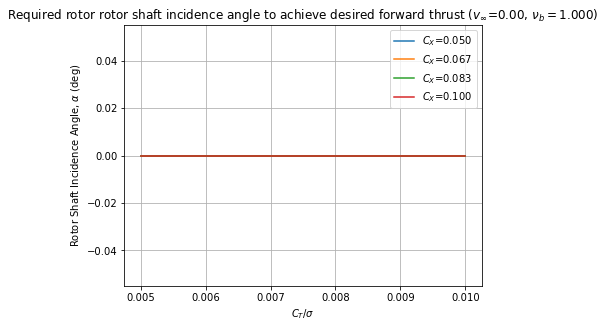

In [3]:
v_inf = knots2mps(0)  # m/s (since vtip is defined in m/s)
nu_b = 1.0

plot_rotor_disc_tilt(CX_list, CT_list, v_inf, nu_b)

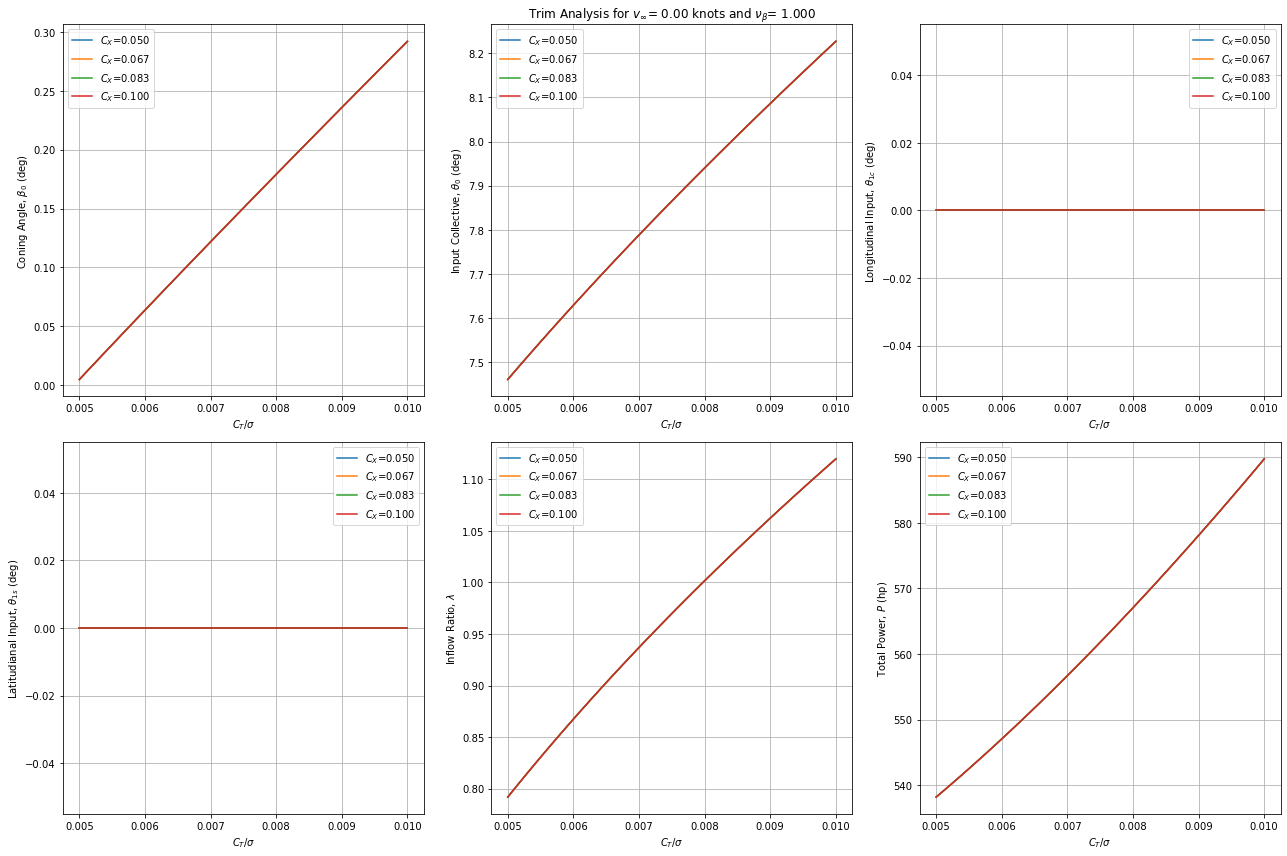

In [4]:
trims = calc_trims_array(CX_list, CT_list, v_inf, nu_b)
trim1_tuple = (CX_list, CT_list, v_inf, nu_b, trims) # info relevant to trim1

plot_rotor_trim(trim1_tuple)

### Trim Analysis in Forward Flight ($v_\infty=25$ knots, $\nu_\beta=1.0$)

In order to achieve this speed of forward flight, the rotor disc must be oriented as shown in the plot below. It makes sense that as forward thrust ($C_X$) increases, the rotor incidence angle must increase. Moreover, if $C_T/\sigma$ is increased, the rotor incidence angle does not have to be as large to achieve a constant $C_X$.

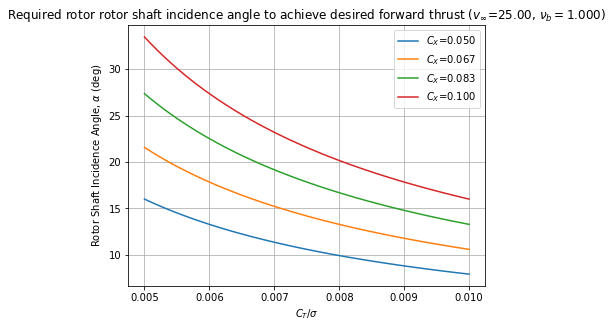

In [5]:
v_inf = knots2mps(25)  # m/s (since vtip is defined in m/s)
nu_b = 1.0

plot_rotor_disc_tilt(CX_list, CT_list, v_inf, nu_b)

Unlike in hover, the curves in the 6 subplots change for different $C_X$ values, and the plots are also more curved. We can see that as $C_X$ increases, all of the controls must increase in magnitude. Notably, $\theta_{1s}$ becomes more negative, while the other curves become more positive. I am a little surprised that the magnitudes of $\theta_{1c}$ and $\theta_{1s}$ are so small. This may indicate an error in my code, as 2 classmates obtained larger cyclic input values, but the same overall behavior of these plots. Nevertheless, the directionality of $\theta_{1s}$ and $\theta_{1c}$ makes sense. In forward flight, the advancing side of the rotor sees a larger free-stream velocity and would therefore experience a larger lift force. In order to prevent flapping, a $-\theta_{1s}$ needs to be used to increase lift on the advancing side, but this also leads to a differential fore/aft lift generation. In order to cancel out this flapping, a $\theta_{1c}$ input must be used.

It is interesting that input collective decreases with $C_T/\sigma$. This is the opposite of what we saw in the trim for hover, where $\theta_0$ and $C_T/\sigma$ are directly proportional. I am not 100% sure about the mechanism behind this, but it is possible that the relative wind contributes so much to the inflow/thrust, that the blade sections themselves do not need to generate as much thrust (via increasing angle of attack). In the section "Effect of forward flight velocity", we will see at what forward velocity this change in behavior occurs.

Lastly, it is interesting to note that total power in forward flight is often less than in hover, and depends on the values of $C_X$ and $C_T$ to make a direct comparison.

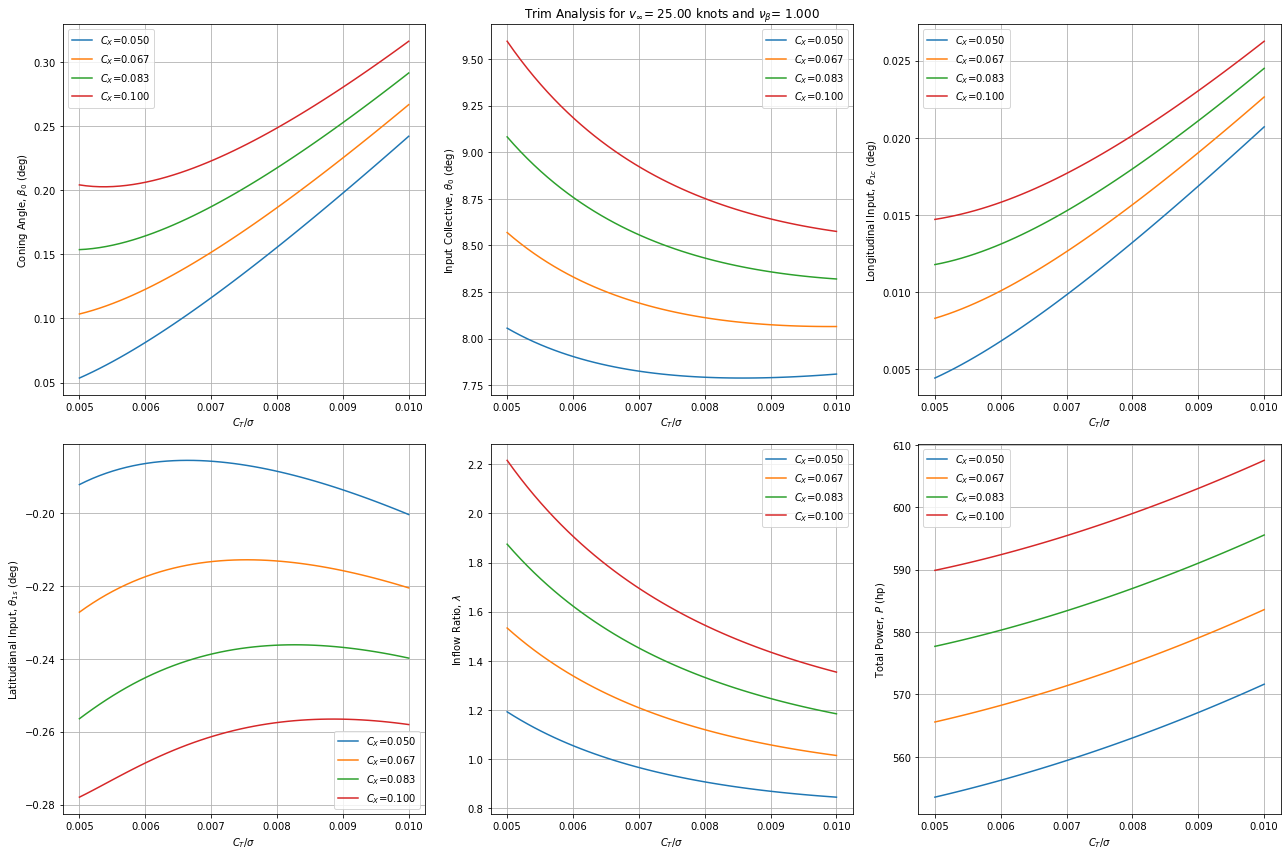

In [6]:
trims = calc_trims_array(CX_list, CT_list, v_inf, nu_b)
trim1_tuple = (CX_list, CT_list, v_inf, nu_b, trims) # info relevant to trim1

plot_rotor_trim(trim1_tuple)

### Trim Analysis in Forward Flight ($v_\infty=33$ knots and $\nu_\beta=1$)

I chose to include $v_\infty=33$ knots because this is approximately the maximum $v_\infty$ for which $\alpha$ exists (within the range of $C_X$). When we consider $v_\infty=50$ knots below, we will see why $\alpha$ can become singular in forward flight, or equivalently, why helicopters have maximum forward flight velocities. The plots of $\theta_{1c}$ and $\theta_{1s}$ below start to show interesting behavior for large values of $C_X$ and small values of $C_T$. This behavior leads up to the singularity in $\alpha$.

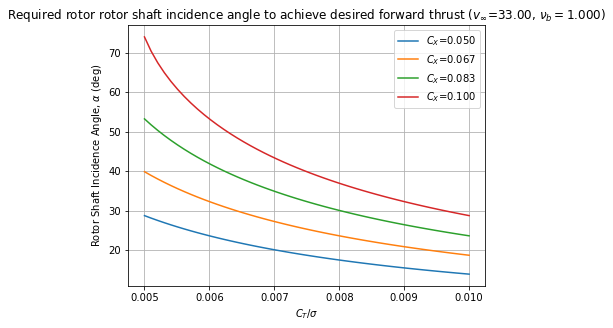

In [7]:
v_inf = knots2mps(33)  # m/s (since vtip is defined in m/s)
nu_b = 1.0

plot_rotor_disc_tilt(CX_list, CT_list, v_inf, nu_b)

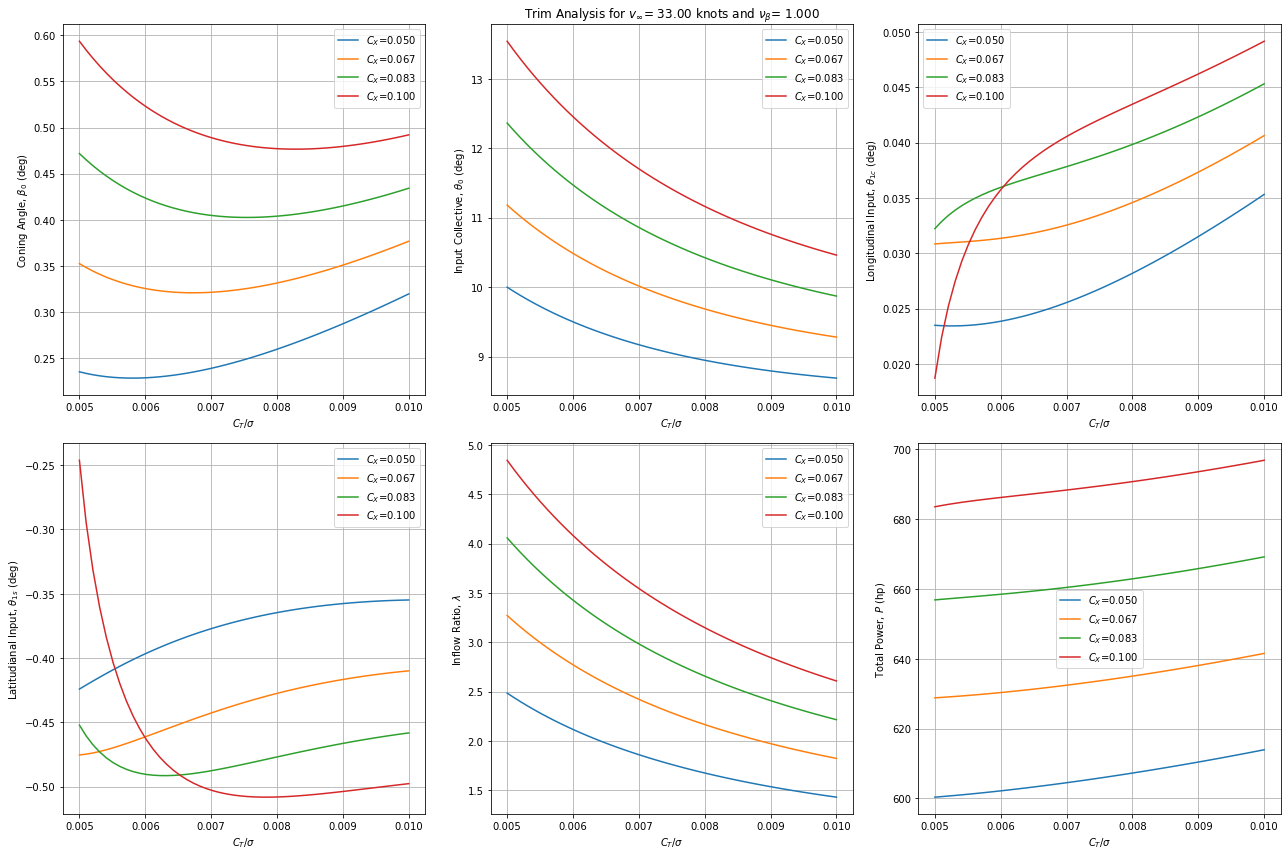

In [8]:
trims = calc_trims_array(CX_list, CT_list, v_inf, nu_b)
trim1_tuple = (CX_list, CT_list, v_inf, nu_b, trims) # info relevant to trim1

plot_rotor_trim(trim1_tuple)

### Trim Analysis in Forward Flight ($v_\infty=50$ knots and $\nu_\beta=1$)

As can be seen in the error messages below, the $\arcsin()$ in the equation for $\alpha$ goes out of range because $$\frac{0.5C_X v^2_\infty}{C_T v^2_{tip}} > 1$$. Moreover, the plot of $\alpha$ vs $C_T/\sigma$ shows where the singularity occurs, near an angle of $\alpha = 1.4^\circ$. For a given $v_\infty$, we have a strict condition on the ratio of $C_X$ to $C_T$ which determines the maximum rotor shaft incidence angle/forward flight velocity:

$$\frac{C_X}{C_T} > \frac{v^2_{tip}}{0.5 v^2_\infty}$$

/Users/nathanielruhl/Desktop/HOV_MEAM5460/HoveringVehicleDesign/proj2/proj2.py:31: RuntimeWarning: invalid value encountered in arcsin
  return np.arcsin((0.5*CX*v_inf**2)/(CT*vtip**2))
/Users/nathanielruhl/Desktop/HOV_MEAM5460/HoveringVehicleDesign/proj2/proj2.py:31: RuntimeWarning: invalid value encountered in arcsin
  return np.arcsin((0.5*CX*v_inf**2)/(CT*vtip**2))
/Users/nathanielruhl/Desktop/HOV_MEAM5460/HoveringVehicleDesign/proj2/proj2.py:31: RuntimeWarning: invalid value encountered in arcsin
  return np.arcsin((0.5*CX*v_inf**2)/(CT*vtip**2))
/Users/nathanielruhl/Desktop/HOV_MEAM5460/HoveringVehicleDesign/proj2/proj2.py:31: RuntimeWarning: invalid value encountered in arcsin
  return np.arcsin((0.5*CX*v_inf**2)/(CT*vtip**2))


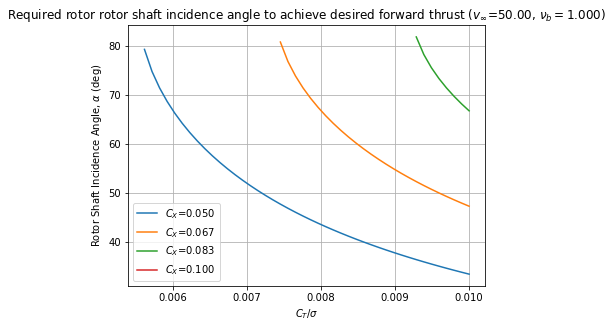

In [9]:
v_inf = knots2mps(50)  # m/s (since vtip is defined in m/s)
nu_b = 1.0

plot_rotor_disc_tilt(CX_list, CT_list, v_inf, nu_b)

/Users/nathanielruhl/Desktop/HOV_MEAM5460/HoveringVehicleDesign/proj2/proj2.py:31: RuntimeWarning: invalid value encountered in arcsin
  return np.arcsin((0.5*CX*v_inf**2)/(CT*vtip**2))
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


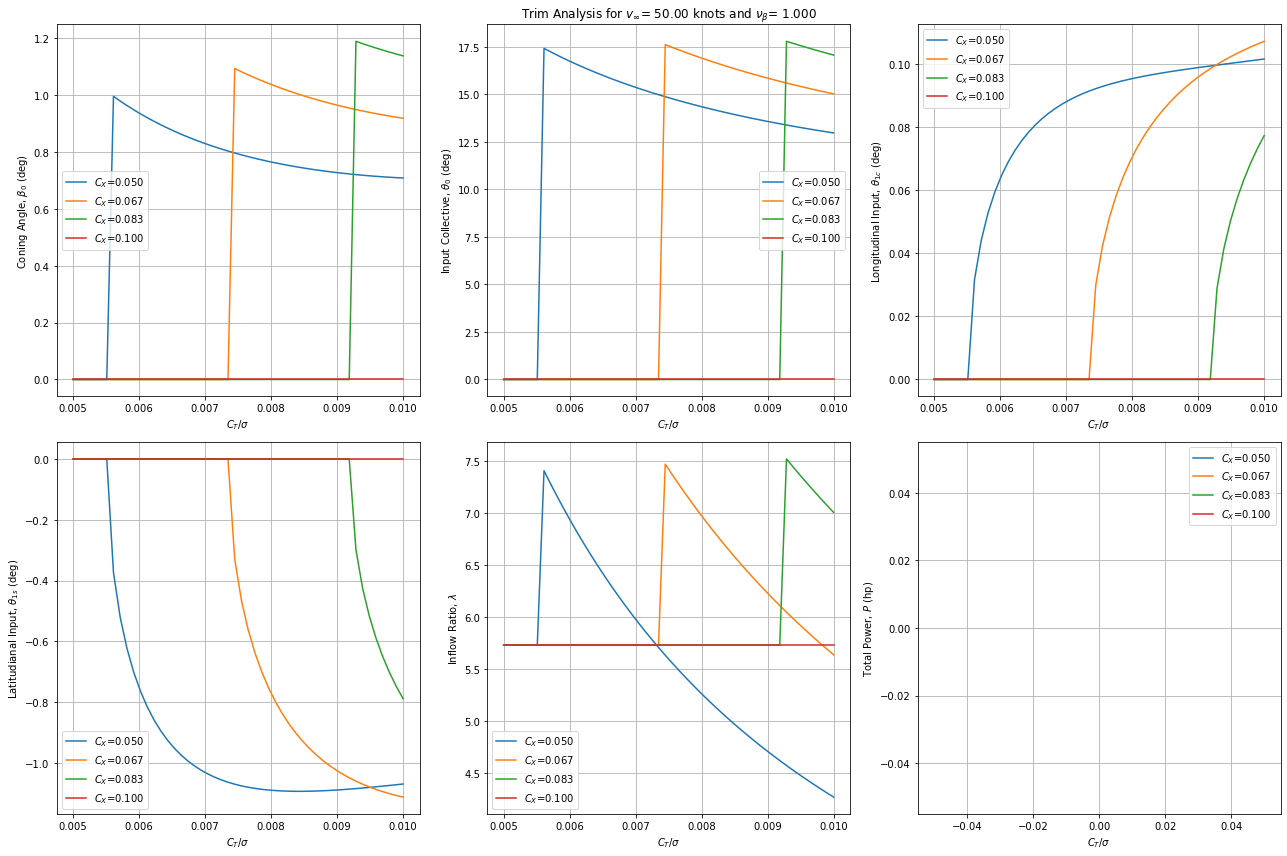

In [10]:
trims = calc_trims_array(CX_list, CT_list, v_inf, nu_b)
trim1_tuple = (CX_list, CT_list, v_inf, nu_b, trims) # info relevant to trim1

plot_rotor_trim(trim1_tuple)

### Effect of varying non-dimensional flap frequency

The non-dimensional flap frequency $\nu_\beta=1$ is an idealization for a centrally-hinged rotor and means that the natural frequency of flapping is equal to the rotational frequency of the rotor. In other words, the input-to-output response is once per revolution. In real life, the rotor hinge will not be at te exact center of the rotor, which adds stiffness to the system, and there is also extra stiffness caused by forward flight. For this reason $\nu_\beta$ may be slightly larger than one.

In order to consider the effects of non-dimension flap frequency, $\nu_\beta$, we will consider $v_\infty=25$ knots and $C_X=0.05$. The effect of $\nu_\beta$ is strong, and the plots of $\beta_0$ and $\theta_{1c}$ do change significantly for different values of $v_\infty$ and $C_X$. Therefore, it is worthwile to re-run these cells for different $v_\infty$ and $C_X$, but the qualitative observations made for the other 4 plots are universal. $\theta_0$, $\theta_{1s}$, $\lambda$, and Total Power are independent of $\nu_\beta$. This is extremely helpful to know when designing and operating the rotor system!

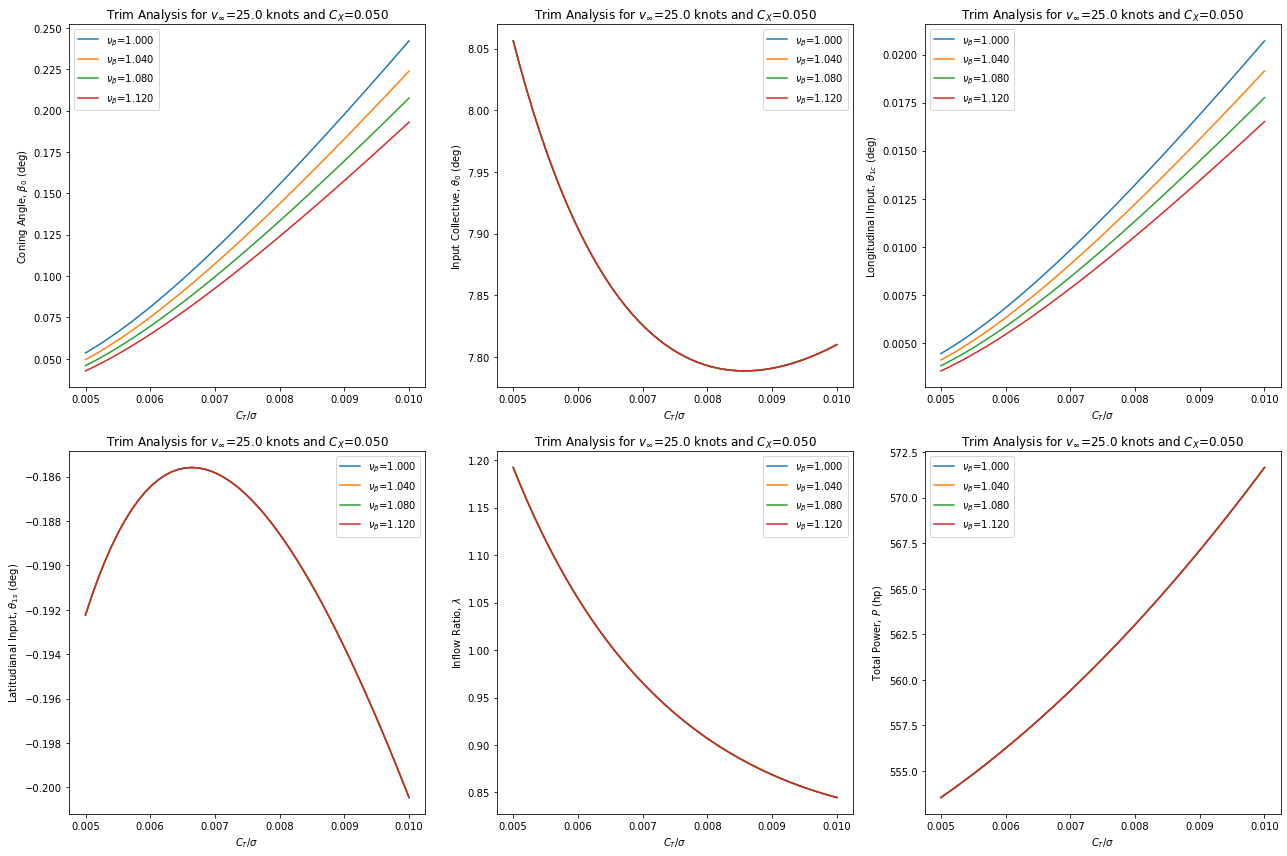

In [11]:
nu_b_list = np.linspace(1.0,1.12,4)
plotter.plot_trim_vary_flap_frequency(nu_b_list, v_inf=knots2mps(25), CX=0.05)

### Effects of Forward Flight Velocity

The cell below shows the aforementioned phenomenon that when forward flight velocity passes $\sim23$ knots, the general relationship between $\theta_0$ and $C_T$ flips directionality. As stated previously, my hypothesis is that the relative wind ends up contributing to thrust, and therefore the airfoils themselves do not need to generate as much thrust via increasing angle of attack.

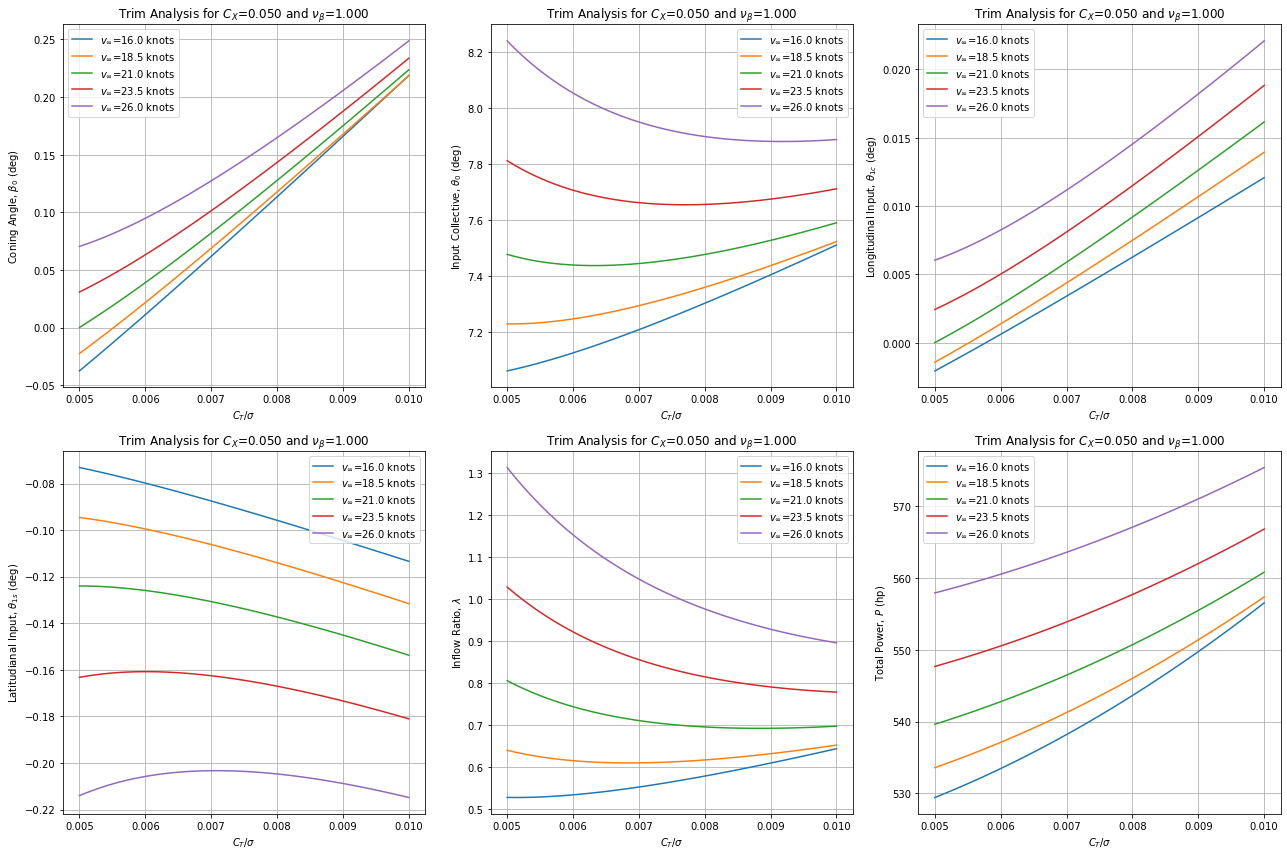

In [12]:
v_inf_list = np.linspace(knots2mps(16),knots2mps(26), 5)
plotter.plot_trim_vary_velocity(v_inf_list, CX=0.05, nu_b=1.0)